In [13]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve

In [14]:
# Get the path of the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

df_real = pd.read_csv(os.path.join(parent_dir, 'workingfolder', 'df_train.csv'))
df_syn = pd.read_csv(os.path.join(parent_dir, 'workingfolder', 'synthetic.csv'))
df_test = pd.read_csv(os.path.join(parent_dir, 'workingfolder', 'df_val.csv'))

In [15]:
len(df_real)

207

In [16]:
df_real.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,34,1,1,118,182,0,2,174,0,0.0,1,0,3,0
1,44,0,3,118,242,0,0,149,0,0.3,2,1,3,0
2,60,1,4,117,230,1,0,160,1,1.4,1,2,7,1
3,43,1,4,110,211,0,0,161,0,0.0,1,0,7,0
4,44,1,2,120,220,0,0,170,0,0.0,1,0,3,0


In [17]:
num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [18]:
scaler = StandardScaler()
scaler_syn = StandardScaler()

# For Real
df_real_processed = df_real.copy(deep = True)
df_real_processed[num_features] = scaler.fit_transform(df_real[num_features])
df_test_processed = df_test.copy(deep = True)
df_test_processed[num_features] = scaler.transform(df_test[num_features])

# For Synthetic
df_syn_processed = df_syn.copy(deep = True)
df_syn_processed[num_features] = scaler_syn.fit_transform(df_syn[num_features])
df_syn_test_processed = df_test.copy(deep = True)
df_syn_test_processed[num_features] = scaler_syn.transform(df_syn_test_processed[num_features])

In [19]:
# Real train
X_real = df_real_processed.drop('target', axis = 1)
y_real = df_real_processed['target']

# Synthetic train
X_syn = df_syn_processed.drop('target', axis = 1)
y_syn = df_syn_processed['target']

# Real testing
X_test = df_test_processed.drop('target', axis = 1)
y_test = df_test_processed['target']

# Synthetic testing
X_test_syn = df_syn_test_processed.drop('target', axis = 1)
y_test_syn = df_syn_test_processed['target']

In [20]:
rfc_real = RandomForestClassifier(n_estimators = 25, max_depth = 5)
rfc_real.fit(X_real, y_real)

RandomForestClassifier(max_depth=5, n_estimators=25)

In [21]:
def performance_metrics(model, X, y):

    y_pred = model.predict(X)

    cm = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(data=cm,
                        index=['True Negative: 0', 'True Positive: 1'],
                        columns=['Pred Negative: 0', 'Pred Positive: 1'])
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')

    print("\n" "#=====#=====#===== Classification Report =====#=====#=====#")
    print(classification_report(y, y_pred))

def plot_evaluation_curves(model, X_train, X_test, y_train, y_test):
    performance_metrics = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for dataset, X, y in [('train', X_train, y_train), ('test', X_test, y_test)]:

        #=====#=====#=====#=====#=====
        # Compute metrics: Accuracy, F1, ROC AUC, Average Precision (AP)
        #=====#=====#=====#=====#=====
        performance_metrics[dataset] = {}

        y_pred = model.predict(X)
        y_pred_prob = model.predict_proba(X)[:, 1]

        # Accuracy
        accuracy = accuracy_score(y, y_pred)
        performance_metrics[dataset]['Accuracy'] = accuracy

        # F1
        f1 = f1_score(y, y_pred)
        performance_metrics[dataset]['F1'] = f1

        # ROC AUC
        roc_auc = roc_auc_score(y, y_pred_prob)
        performance_metrics[dataset]['ROC_AUC'] = roc_auc

        # Average Precision (AP)
        average_precision = average_precision_score(y, y_pred_prob)
        performance_metrics[dataset]['Average_Precision'] = average_precision

        #=====#=====#=====#=====#=====
        # Plot curves: F1 score, ROC, PRC
        #=====#=====#=====#=====#=====
        color = 'blue' if dataset == 'train' else 'orange'

        # F1 score
        thresholds = np.linspace(start=0, stop=1, num=100, endpoint=True)
        f1_scores = [f1_score(y, y_pred_prob >= th) for th in thresholds]
        max_f1_score_idx = np.argmax(f1_scores)

        ax = axs[0]
        ax.plot(thresholds, f1_scores, color=color, label=f"{dataset}, max={round(f1_scores[max_f1_score_idx], 2)} @ {round(thresholds[max_f1_score_idx], 2)}")
        # mark some thresholds
        for th in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            closest_threshold_idx = np.argmin(np.abs(thresholds-th))
            marker_color = 'red'
            ax.plot(thresholds[closest_threshold_idx], f1_scores[closest_threshold_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('decision function threshold')
        ax.set_ylabel('F1')
        ax.set_title('F1 Score')
        ax.legend(loc='lower center')


        # ROC
        fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f"{dataset}, ROC AUC={round(roc_auc, 2)}")
        # mark some thresholds
        for th in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            closest_threshold_idx = np.argmin(np.abs(thresholds-th))
            marker_color = 'red'
            ax.plot(fpr[closest_threshold_idx], tpr[closest_threshold_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('ROC Curve')
        ax.legend(loc='lower center')

        # PRC
        precision, recall, thresholds = precision_recall_curve(y, y_pred_prob)

        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f"{dataset}, Average Precision={round(average_precision, 2)}")
        # mark some thresholds
        for th in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            closest_threshold_idx = np.argmin(np.abs(thresholds-th))
            marker_color = 'red'
            ax.plot(recall[closest_threshold_idx], precision[closest_threshold_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision Recall Curve')
        ax.legend(loc='lower center')


    df_performance_metrics = pd.DataFrame(performance_metrics).round(2)
    display(df_performance_metrics)



#=====#=====#===== Classification Report =====#=====#=====#
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        49
           1       0.85      0.83      0.84        41

    accuracy                           0.86        90
   macro avg       0.85      0.85      0.85        90
weighted avg       0.86      0.86      0.86        90



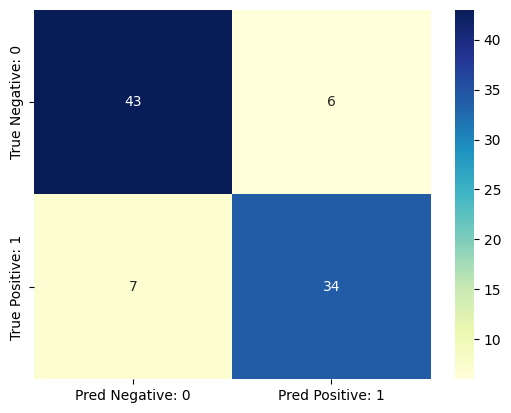

In [22]:
performance_metrics(rfc_real, X_test, y_test)

,train,test
Accuracy,0.95,0.86
F1,0.94,0.84
ROC_AUC,0.99,0.93
Average_Precision,0.99,0.93


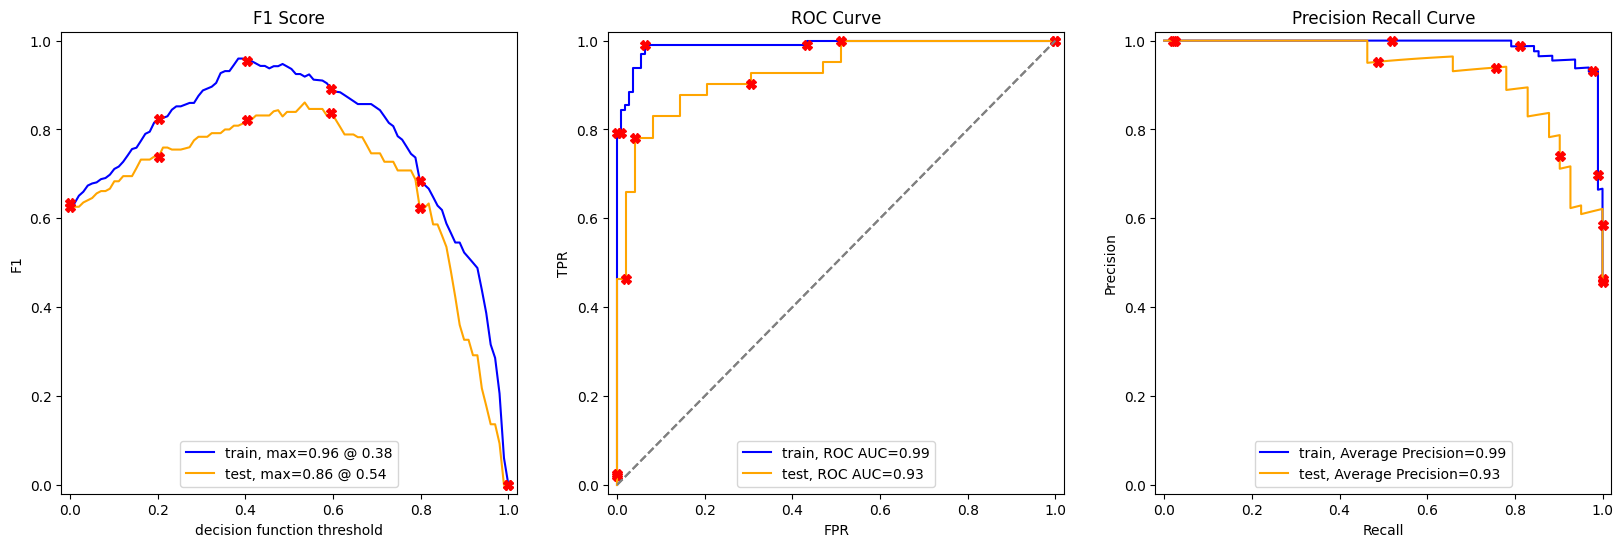

In [28]:
plot_evaluation_curves(rfc_real, X_real, X_test, y_real, y_test)

In [23]:
rfc_syn = RandomForestClassifier(n_estimators = 25, max_depth = 5)
rfc_syn.fit(X_syn, y_syn)

RandomForestClassifier(max_depth=5, n_estimators=25)


#=====#=====#===== Classification Report =====#=====#=====#
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        99
           1       0.92      0.95      0.94       111

    accuracy                           0.93       210
   macro avg       0.93      0.93      0.93       210
weighted avg       0.93      0.93      0.93       210



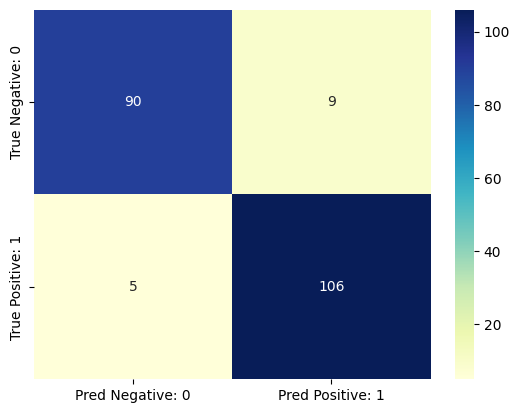

In [24]:
performance_metrics(rfc_syn, X_syn, y_syn)


#=====#=====#===== Classification Report =====#=====#=====#
              precision    recall  f1-score   support

           0       0.46      0.33      0.38        49
           1       0.40      0.54      0.46        41

    accuracy                           0.42        90
   macro avg       0.43      0.43      0.42        90
weighted avg       0.43      0.42      0.42        90



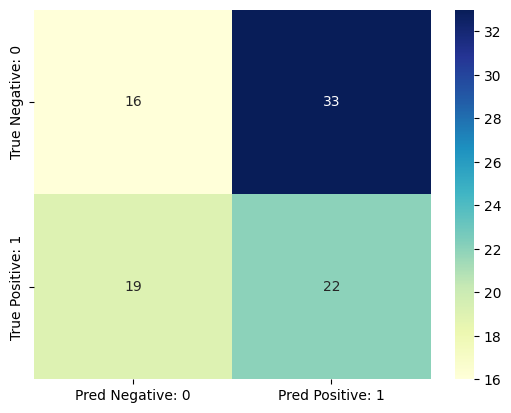

In [25]:
performance_metrics(rfc_syn, X_test_syn, y_test_syn)

,train,test
Accuracy,0.95,0.86
F1,0.94,0.84
ROC_AUC,0.99,0.93
Average_Precision,0.99,0.93


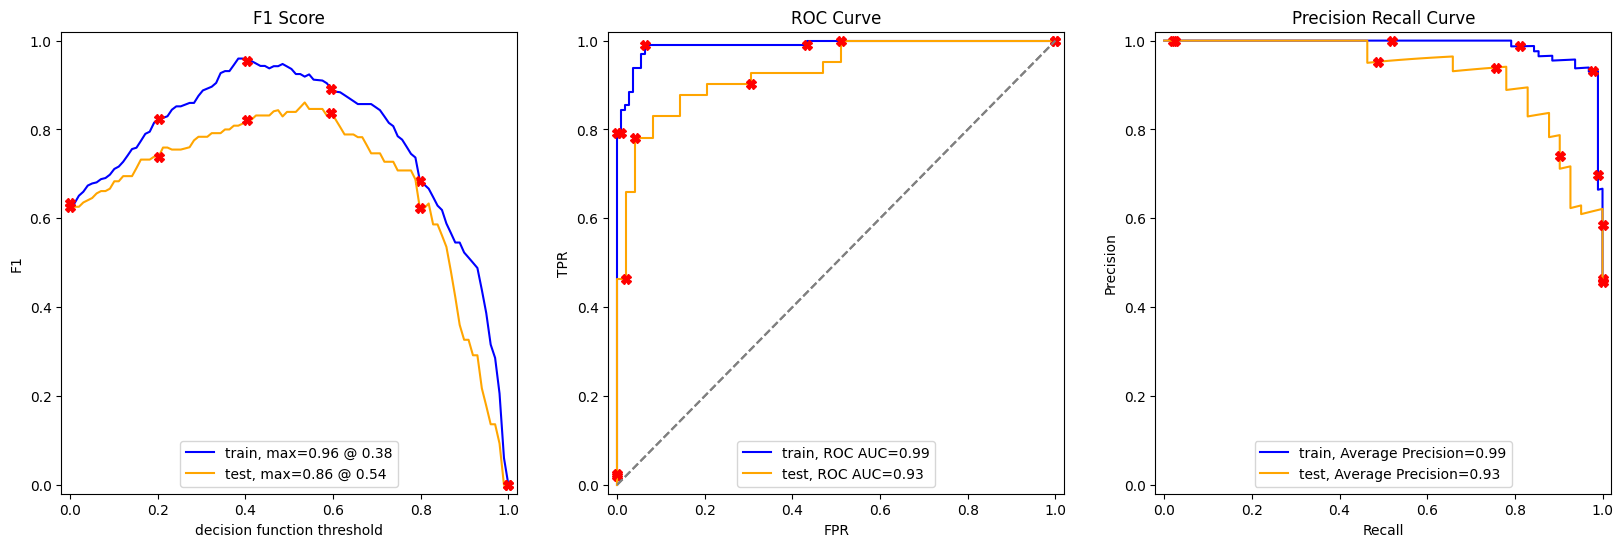

,train,test
Accuracy,0.93,0.42
F1,0.94,0.46
ROC_AUC,0.99,0.42
Average_Precision,0.99,0.42


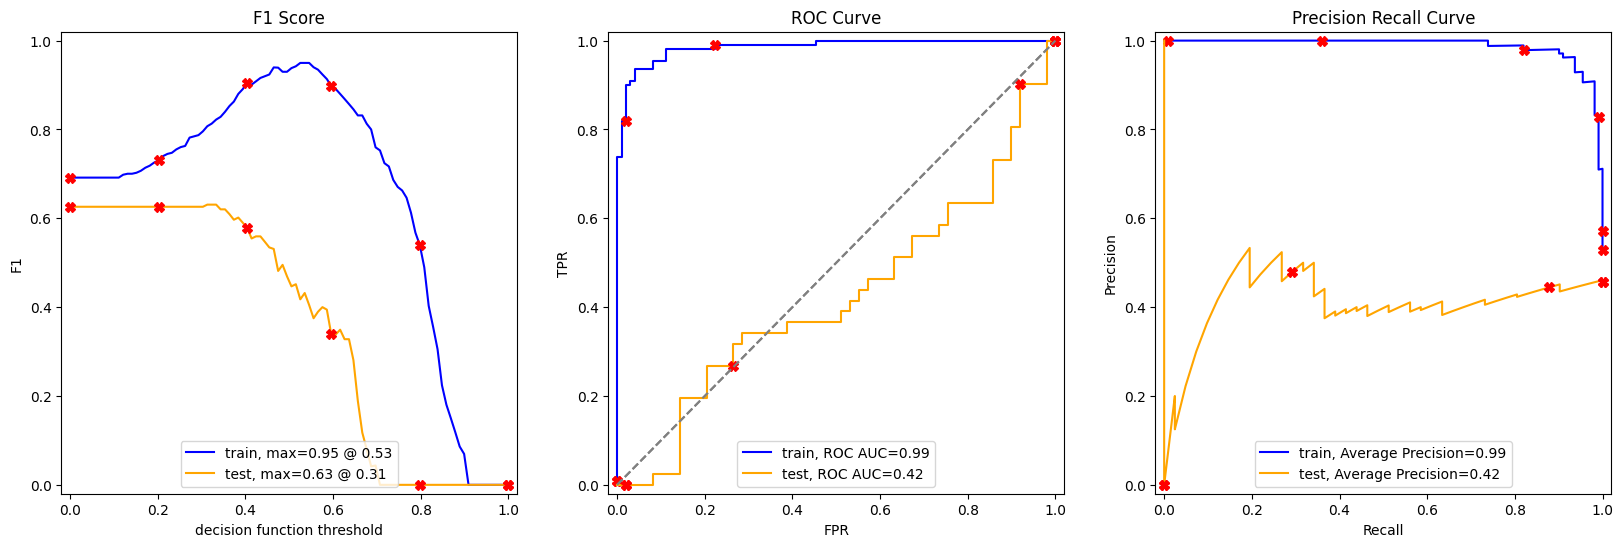

In [27]:
plot_evaluation_curves(rfc_syn, X_syn, X_test_syn, y_syn, y_test_syn)